In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from tqdm import tqdm

## 데이터 불러오기

In [2]:
raw_data=pd.read_csv('./data09/funda_train.csv')
data=raw_data.copy()
data.info()
#data.describe()  
# 날짜 헷갈리니까 합친다.
# 환불 금액이 보임. 환불을 먼저 없앤다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


## 데이터 기본정보

In [3]:
num_store=len(data.store_id.unique())
num_card=len(data.card_company.unique())
num_region=len(data.region.unique())
num_business=len(data.type_of_business.unique())
num_installment=len(data.installment_term.unique())

print(f'store_id : {num_store}')
print(f'card_company : {num_card}')
print(f'region : {num_region}')
print(f'type_of_business : {num_business}')
print(f'installment_term : {num_installment}',end='\n')

data.info()

store_id : 1967
card_company : 8
region : 181
type_of_business : 146
installment_term : 34
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


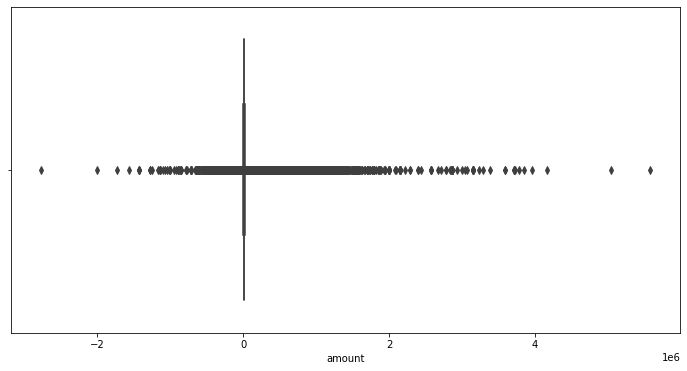

In [4]:
plt.figure(figsize=(12,6))
sns.boxplot(x='amount',data=data)

In [5]:
data.isna().sum()

print('region nan data :',(data.region.isna().sum()/len(data)).round(3))
print('type_of_business nan data :',(data.type_of_business.isna().sum()/len(data)).round(3))

region nan data : 0.312
type_of_business nan data : 0.603


1. 데이터 갯수가 60만개 이상 > 보통의 방법으로는 처리시간이 많이 걸림. > store_id로 나눠 생각한다.
2. transacted_date와 transacted_time 을 합쳐 datetime 형식으로 바꾼다. > 시계열 데이터 처리를 위한다.
3. 숫자형 데이터의 describe()를 봤을 때, amount의 음수가 있다.         > 환불 데이터는 후에 처리할 정보의 영향을 줄 수 있으므로 제거한다.
4. 시계열 데이터를 위해 월별 데이터를 모은다.  
5. 결측율이 region과 type_of_business 가 각각 30%와 60%를 넘어가며, 채우는데 더 오랜 시간이 걸릴걸로 보아 제거한다. 

## 환불금액 제거.

In [ ]:
#합치기
data['date']=data['transacted_date']+' '+data['transacted_time']
data['date']=pd.to_datetime(data['date'])
#환불 제거
data_neg=data[data['amount']<0]
data_pos=data[data['amount']>0]
remove_data=pd.DataFrame()
# store_id 안나누고 하니까 시간이 너무 오래걸림. 
for i in tqdm(data.store_id.unique()):
    divided_data=data_pos[data_pos['store_id']==i] 
    divided_data2=data_neg[data_neg['store_id']==i] 
    #행 마다 조사.    
    for neg in divided_data2.to_records():  
        refund_store=neg['store_id']
        refund_id=neg['card_id'] 
        refund_date=neg['date']
        refund_amount=abs(neg['amount'])
        #행뽑기
        row=divided_data[divided_data['date']<=refund_date]
        row=row[row['card_id']==refund_id]
        row=row[row['amount']==refund_amount]
        
        if(len(row)!=0):
            refund_date=max(row['date']) 
            remove=divided_data[divided_data['date']==refund_date] 
            remove=remove[remove['card_id']==refund_id] 
            remove=remove[remove['amount']==refund_amount] 
            divided_data=divided_data.drop(index=remove.index) 

    remove_data=pd.concat([remove_data,divided_data],axis=0)

remove_data

#remove_data.to_csv('./data09/funda_remove_data.csv')

In [6]:
data=pd.read_csv('./data09/funda_remove_data.csv',index_col=0)
data['date_slice']=pd.to_datetime(data['date'].str.slice(stop=10))
data=data.set_index('date_slice')
#data.head(3)

C:\Users\ckdck\miniconda3\envs\tensor\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


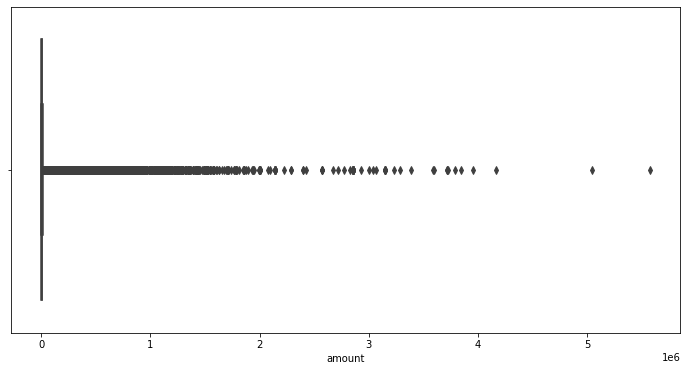

In [7]:
plt.figure(figsize=(12,6))
sns.boxplot(x='amount',data=data)

In [8]:
data_month=pd.DataFrame()
for i in tqdm(data.store_id.unique()):
    data_num=data[data.store_id==i]
    sum_amount=data_num['amount'].resample(rule='m').sum()
    data_mon=pd.concat([sum_amount],axis=1)
    data_mon.insert(0,'store_id',i)
    data_month=pd.concat([data_month,data_mon],axis=0)
    
#data_month.head(10)

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:49<00:00, 39.77it/s]


## 단순 이동 평균

In [9]:
def sub(df,n):
    concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))
    df_sma=pd.DataFrame(columns=['store_id','amount'])

    for i in data_month.store_id.unique():
        df_set = pd.DataFrame(df[df.store_id == i].amount)
        sma_train = pd.concat([df_set,concat_3mon], axis=0)
        num = df_set.amount.rolling(window=n,min_periods=1).mean().values[-3:].sum()
        df_sma.loc[i,'store_id']=i
        df_sma.loc[i,'amount']=num
        
    return df_sma

In [ ]:
for i in tqdm(range(4, 7)):
    sma_sub = sub(data_month, i)
    sma_sub.to_csv(f'./data09/funda_{i}sma_sub.csv',index=False)